In [2]:
from matplotlib import pyplot as plt
import platform, os, sys
import numpy as np
from tabulate import tabulate
from pprint import pprint
from importlib import reload

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal

%matplotlib inline
%config InlineBackend.figure_format='retina'

Could not import BEM module. Please do so manually.


In [3]:
reload(interpolate_slow)

<module 'BEMHelper.interpolate_slow' from '/Users/gkoolstra/Documents/Code/BEMHelper/interpolate_slow.py'>

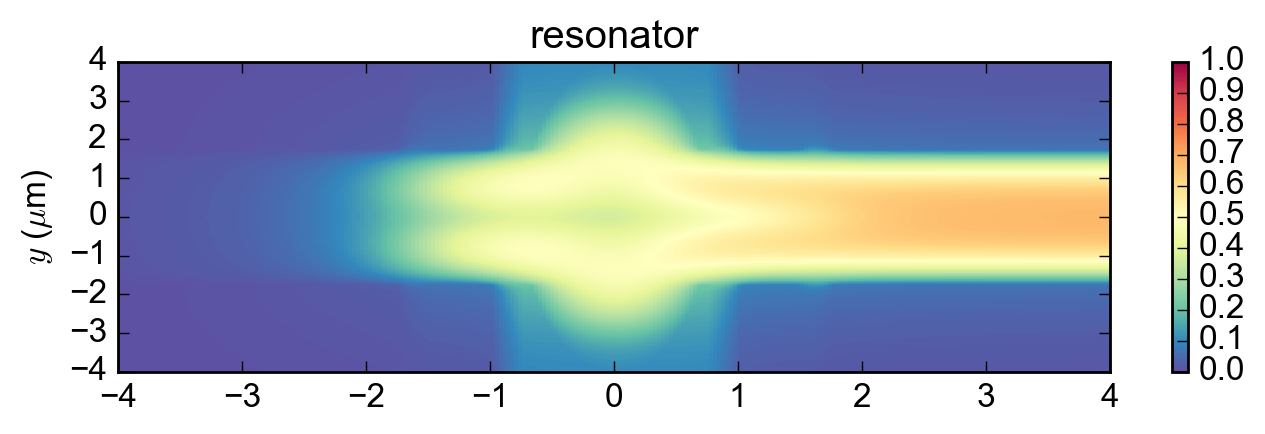

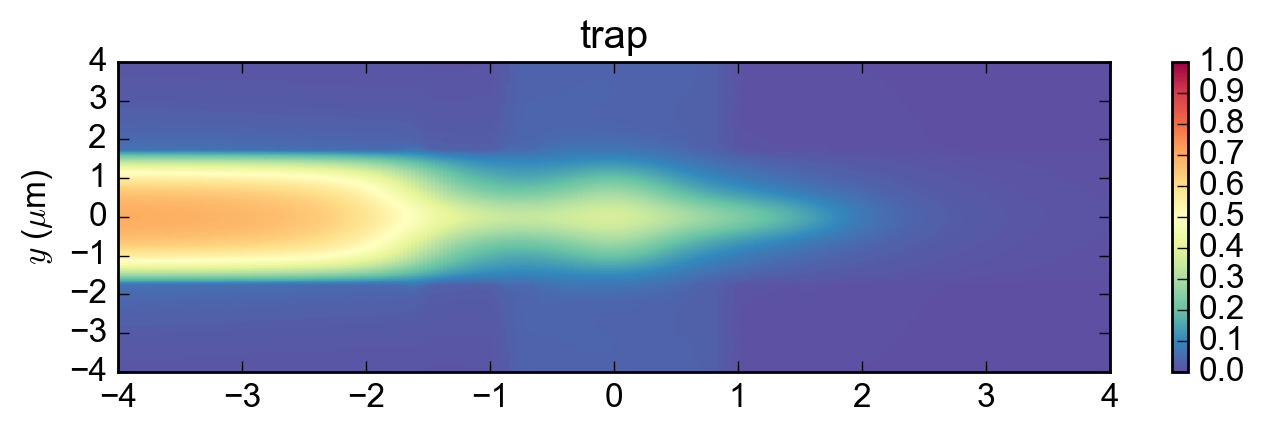

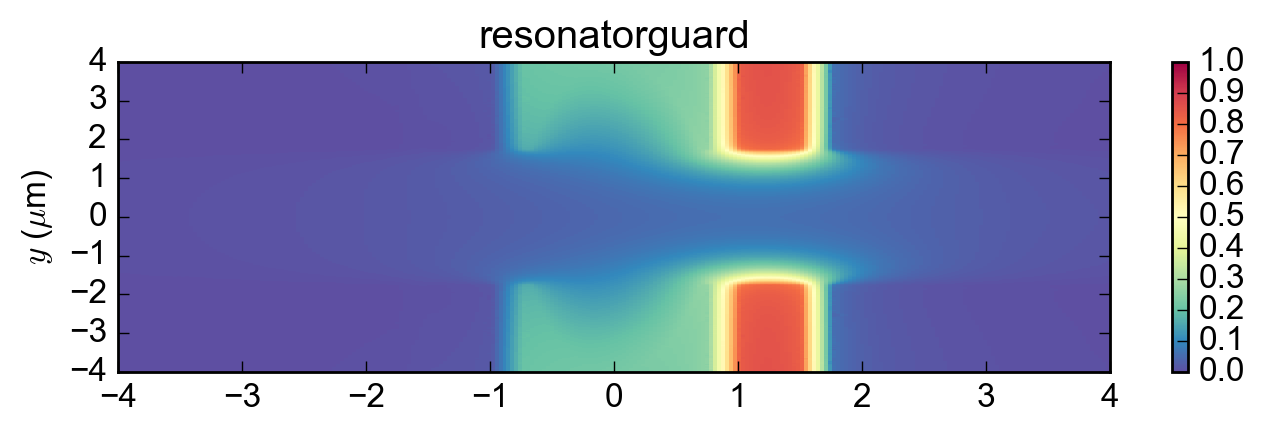

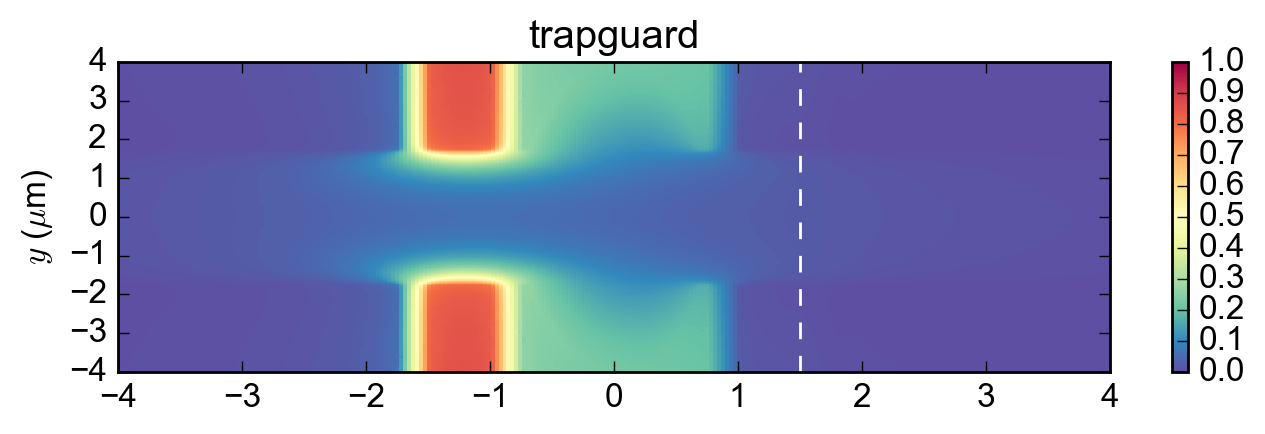

In [4]:
# Evaluate all files in the range
xeval = np.linspace(-4, 4, 251)
yeval = anneal.construct_symmetric_y(-4, 251)

save = True
save_path = r"/Volumes/slab/Gerwin/Electron on helium/Maxwell/M018 Yggdrasil/M018V4"
datafiles = [os.path.join(save_path, "Resonator.dsp"),
             os.path.join(save_path, "Trap.dsp"),
             os.path.join(save_path, "ResonatorGuard.dsp"), 
             os.path.join(save_path, "TrapGuard.dsp")]

output = list()
names = ['resonator', 'trap', 'resonatorguard', 'trapguard']
plt.figure(figsize=(14.,4.))
common.configure_axes(13)

x_eval, y_eval, output = anneal.load_data(save_path, xeval=xeval, yeval=yeval, mirror_y=True,
                                         extend_resonator=False, insert_resonator=False, do_plot=True, 
                                         inserted_res_length=20E-6)

plt.vlines(1.50, np.min(yeval), -np.min(yeval), linestyles="--", color="white")

# How strong do electrodes contribute to barrier potential $V_b$?

We would like to describe the potential at the barrier in terms of the resonator voltage $V_r$ and the resonator guard $V_{rg}$: 

$$ V_b = \alpha V_{res} + \beta V_{trap} + \gamma V_{rg} + \delta V_{cg} + \epsilon V_{tg}$$

To find $\alpha$ through $\epsilon$ let's plot the energy across the channel when 1V is applied to each of the electrodes:

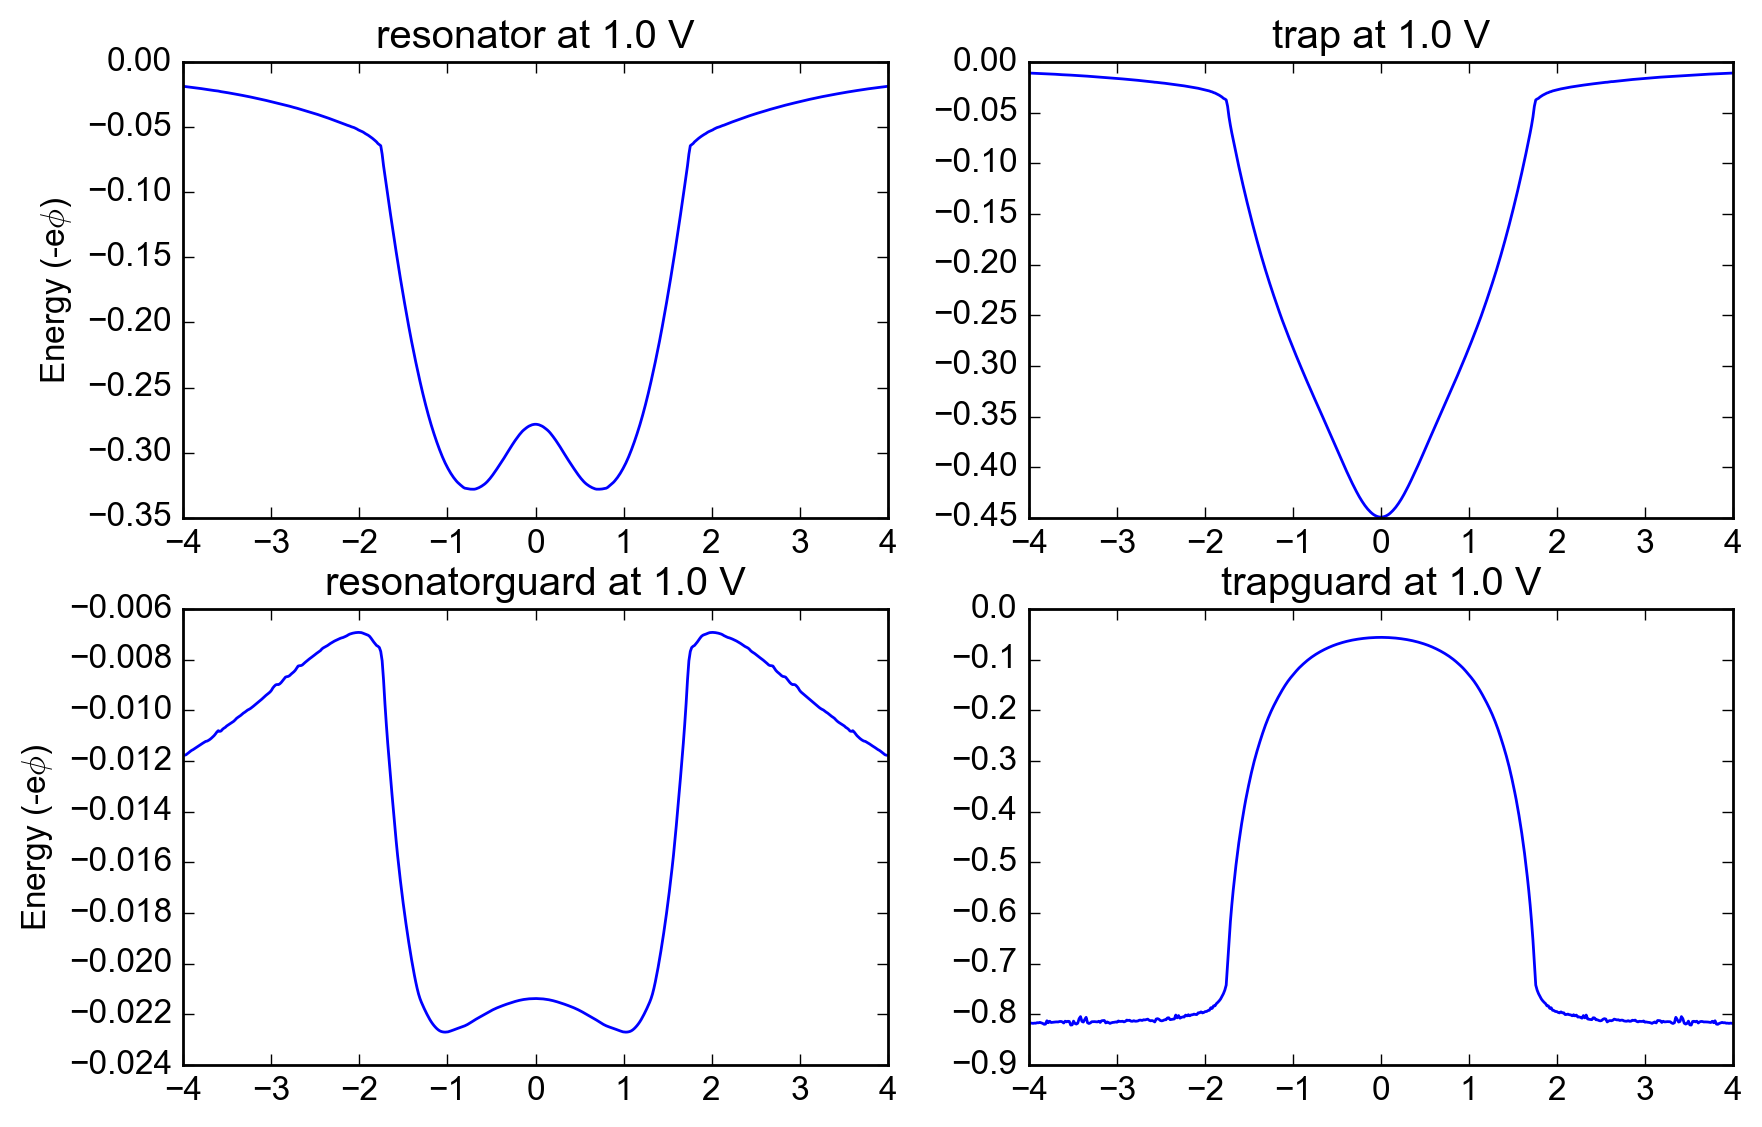

In [5]:
xoi = -1.50
xoi_idx = common.find_nearest(xeval, xoi)
ctr_idx = common.find_nearest(y_eval[:,0], 0)

names = ['alpha', 'beta', 'gamma', 'delta']
voltage_coefficients = list()

fig = plt.figure(figsize=(10.,10.))
    
for i in range(4):
    plt.subplot("32%d"%(i+1))
    plt.plot(y_eval[:,0]*1E6, -output[i]['V'][xoi_idx, :])
    if not i%2:
        plt.ylabel("Energy (-e$\phi$)")
    #if i in [4,5]:
    #    plt.xlabel("x ($\mu$m)")
    plt.title("%s at 1.0 V"%output[i]['name'])

#    print("%s = %.3f"%(names[i], output[i]['V'][xoi_idx,ctr_idx]))
    
    voltage_coefficients.append(output[i]['V'][xoi_idx, ctr_idx])
    
#if save: 
#    common.save_figure(fig, save_path=save_path)

In [6]:
print(voltage_coefficients)

[0.27817684809671411, 0.44930053739876885, 0.021380425516315558, 0.055991479943372544]
